In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


In [27]:
#uvoz skupa podataka

df = pd.read_csv('../freMTPL2freq.csv')
df = df.sample(n=100000, random_state=42)
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
261354,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
448143,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
188618,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
12952,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
425028,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


In [28]:
df.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [29]:
df.duplicated().sum()

0

In [30]:
# izvaci redove gde je ClaimNb veca od 4
df = df[df['ClaimNb'] <= 4]

In [31]:
# Nova kolona: da li je vozač imao bar jednu štetu
df['ClaimNb'] = df['ClaimNb'].apply(lambda x: 1 if x > 0 else 0)

In [32]:
# Izbor karakteristika i enkodiranje kategorijskih atributa
# Ukloni IDpol i ClaimNb iz features
features = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'Exposure', 'BonusMalus', 'VehPower', 'BonusMalus', 'Area']

X = df[['DrivAge', 'VehPower', 'BonusMalus', 'Area', 'Density']]
X = pd.get_dummies(X, columns=['VehPower', 'BonusMalus', 'Area'])


y = df['ClaimNb']

In [33]:
y.unique()

array([0, 1], dtype=int64)

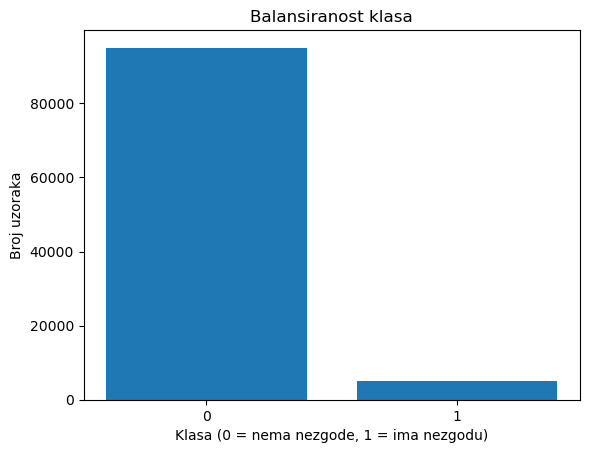

In [34]:
# Provjera balansiranosti klasa 
class_counts = y.value_counts()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xlabel('Klasa (0 = nema nezgode, 1 = ima nezgodu)')
plt.ylabel('Broj uzoraka')
plt.title('Balansiranost klasa')
plt.show()

In [35]:
X.describe()

,DrivAge,Density
count,99999.000000,99999.000000
mean,45.519965,1798.086511
std,14.147228,3949.520250
min,18.000000,2.000000
25%,34.000000,93.000000
50%,44.000000,393.000000
75%,55.000000,1662.000000
max,99.000000,27000.000000


In [36]:
# Podela na trening i test skupove (70% train, 30% test), stratifikacija po klasama
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify=y)


In [37]:
#zbog velike nebalansiranosti klasa
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [38]:
print(type(X_train))  # mora biti <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>


In [39]:
# Skaliranje podataka (MinMaxScaler)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [40]:
X_train

array([[0.74074074, 0.01118601, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.20987654, 0.06907919, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.25925926, 0.08922883, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.19753086, 0.11500852, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.16049383, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.41975309, 0.15238166, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [41]:
X_test

array([[0.34567901, 0.00700052, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.81481481, 0.14312171, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2345679 , 0.01248241, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.37037037, 0.01607526, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.55555556, 0.00455589, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16049383, 0.02266835, 0.        , ..., 1.        , 0.        ,
        0.        ]])

## kNN

In [42]:
# Kreiranje i treniranje osnovnog KNN modela (sa default parametrima)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [43]:
# Predikcije na train i test skupovima
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

In [44]:
# Evaluacija modela
print("Klasifikacioni izveštaj (Train skup):")
print(classification_report(y_train, y_pred_train))


print("Klasifikacioni izveštaj (Test skup):")
print(classification_report(y_test, y_pred_test))

Klasifikacioni izveštaj (Train skup):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     66502
           1       0.97      0.94      0.96     66502

    accuracy                           0.96    133004
   macro avg       0.96      0.96      0.96    133004
weighted avg       0.96      0.96      0.96    133004

Klasifikacioni izveštaj (Test skup):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     28501
           1       0.08      0.09      0.08      1499

    accuracy                           0.91     30000
   macro avg       0.52      0.52      0.52     30000
weighted avg       0.91      0.91      0.91     30000



In [45]:
# Prikazuje konfuzionu matricu kao DataFrame
labels = sorted(np.unique(y_train))
cm = confusion_matrix(y_train, y_pred_train, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("Konfuziona matrica (Training set):")
print(cm_df)

Konfuziona matrica (Training set):
       0      1
0  64331   2171
1   3722  62780


In [46]:
# Prikaz konfuzione matrice kao heatmap
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predviđene klase')
    plt.ylabel('Prave klase')
    plt.title(f'Konfuziona matrica - {dataset_name}')
    plt.show()

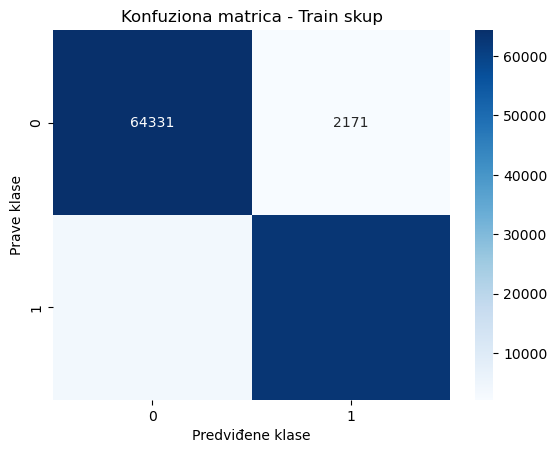

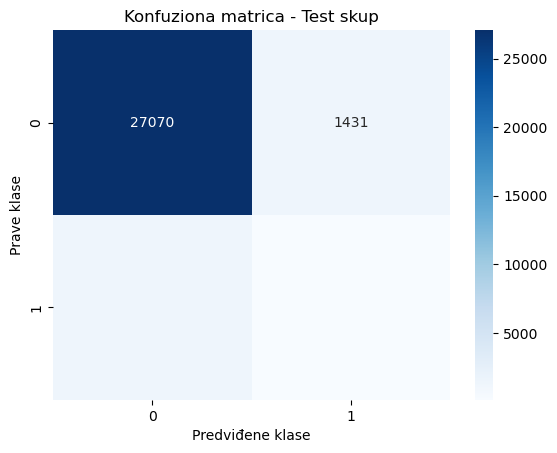

In [47]:
plot_confusion_matrix(y_train, y_pred_train, 'Train skup')
plot_confusion_matrix(y_test, y_pred_test, 'Test skup')

In [48]:
print('Train skup - Matrica konfuzije:')
print(confusion_matrix(y_train, y_pred_train))

print('Test skup - Matrica konfuzije:')
print(confusion_matrix(y_test, y_pred_test))

Train skup - Matrica konfuzije:
[[64331  2171]
 [ 3722 62780]]
Test skup - Matrica konfuzije:
[[27070  1431]
 [ 1371   128]]


## GridSearchCV

In [49]:
#U rečniku čuvamo informacije o imenima i vrijednostima parametara koje želimo da ispitamo

params = {
    'n_neighbors': range(5, 31, 5),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 -> Manhattan, p=2 -> Euclidean
}

In [50]:
# GridSearchCV sa 3-fold cross-validation
#grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 31, 5), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [51]:
# Prikaz najboljih parametara
print("Najbolji parametri:", grid_search.best_params_)
print("Najbolja tačnost na validaciji:", grid_search.best_score_)

Najbolji parametri: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Najbolja tačnost na validaciji: 0.9420620255997255


In [52]:
# Korišćenje najboljeg modela sa GridSearch-a
best_knn = grid_search.best_estimator_

In [53]:
y_pred_train_best = best_knn.predict(X_train)
y_pred_test_best = best_knn.predict(X_test)

In [54]:
# Evaluacija

print("Klasifikacioni izveštaj sa najboljim modelom (Train skup):")
print(classification_report(y_train, y_pred_train_best))

print("Klasifikacioni izveštaj sa najboljim modelom (Test skup):")
print(classification_report(y_test, y_pred_test_best))

Klasifikacioni izveštaj sa najboljim modelom (Train skup):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     66502
           1       0.99      0.99      0.99     66502

    accuracy                           0.99    133004
   macro avg       0.99      0.99      0.99    133004
weighted avg       0.99      0.99      0.99    133004

Klasifikacioni izveštaj sa najboljim modelom (Test skup):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     28501
           1       0.07      0.08      0.08      1499

    accuracy                           0.90     30000
   macro avg       0.51      0.51      0.51     30000
weighted avg       0.91      0.90      0.91     30000



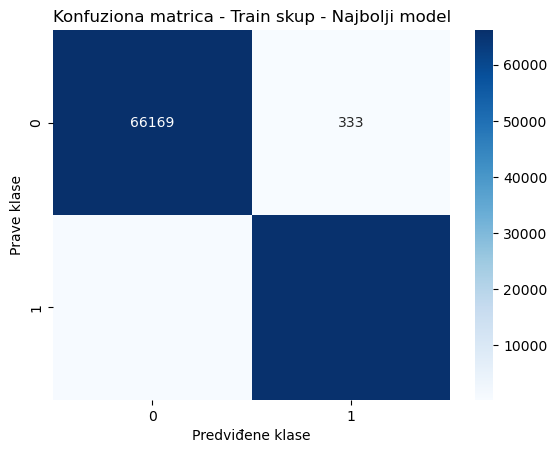

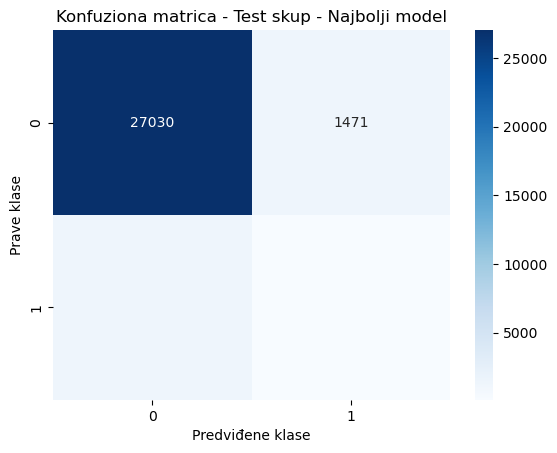

In [55]:
plot_confusion_matrix(y_train, y_pred_train_best, 'Train skup - Najbolji model')
plot_confusion_matrix(y_test, y_pred_test_best, 'Test skup - Najbolji model')

In [56]:
print('Train skup - Matrica konfuzije:')
print(confusion_matrix(y_train, y_pred_train))

print('Test skup - Matrica konfuzije:')
print(confusion_matrix(y_test, y_pred_test))


Train skup - Matrica konfuzije:
[[64331  2171]
 [ 3722 62780]]
Test skup - Matrica konfuzije:
[[27070  1431]
 [ 1371   128]]


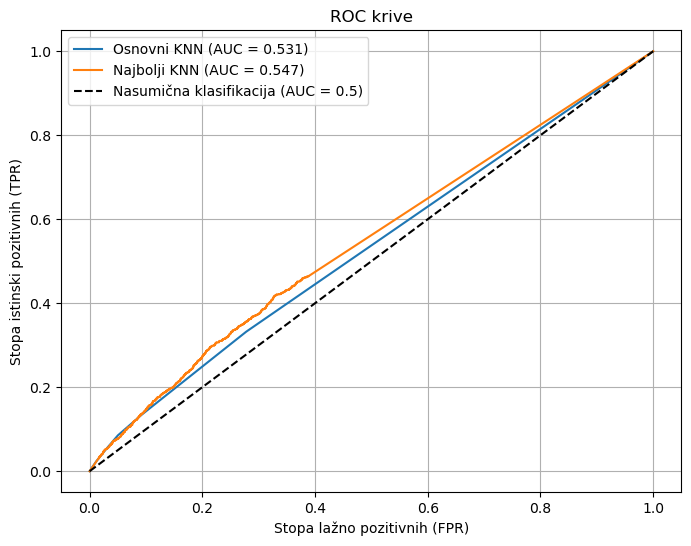

In [57]:
# ROC krive i AUC za osnovni i najbolji model
y_scores_basic = knn.predict_proba(X_test)[:, 1]
y_scores_best = best_knn.predict_proba(X_test)[:, 1]

fpr_basic, tpr_basic, _ = roc_curve(y_test, y_scores_basic)
fpr_best, tpr_best, _ = roc_curve(y_test, y_scores_best)

auc_basic = roc_auc_score(y_test, y_scores_basic)
auc_best = roc_auc_score(y_test, y_scores_best)

plt.figure(figsize=(8,6))
plt.plot(fpr_basic, tpr_basic, label=f'Osnovni KNN (AUC = {auc_basic:.3f})')
plt.plot(fpr_best, tpr_best, label=f'Najbolji KNN (AUC = {auc_best:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Nasumična klasifikacija (AUC = 0.5)')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa istinski pozitivnih (TPR)')
plt.title('ROC krive')
plt.legend()
plt.grid()
plt.show()


In [58]:
# Poređenje tačnosti (accuracy), preciznosti, recall i F1-score
results = {
    'Skup': ['Train', 'Test'],
    'Accuracy (Osnovni)': [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)],
    'Accuracy (Najbolji)': [accuracy_score(y_train, y_pred_train_best), accuracy_score(y_test, y_pred_test_best)],
    'Precision (Najbolji)': [precision_score(y_train, y_pred_train_best), precision_score(y_test, y_pred_test_best)],
    'Recall (Najbolji)': [recall_score(y_train, y_pred_train_best), recall_score(y_test, y_pred_test_best)],
    'F1-score (Najbolji)': [f1_score(y_train, y_pred_train_best), f1_score(y_test, y_pred_test_best)],
}

results_df = pd.DataFrame(results)
print(results_df)

    Skup  Accuracy (Osnovni)  Accuracy (Najbolji)  Precision (Najbolji)  \
0  Train            0.955693             0.992692              0.994969   
1   Test            0.906600             0.904967              0.074843   

   Recall (Najbolji)  F1-score (Najbolji)  
0           0.990391             0.992675  
1           0.079386             0.077048  


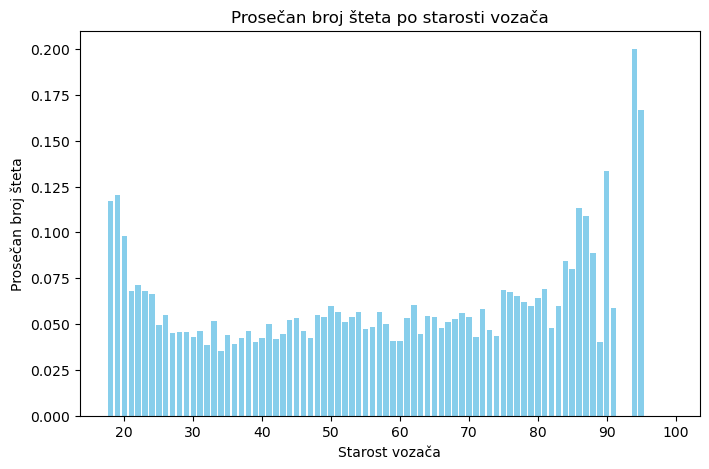

In [59]:
# Analiza prosečnih šteta po starosti vozača
age_claims = df.groupby('DrivAge')['ClaimNb'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.bar(age_claims['DrivAge'], age_claims['ClaimNb'], color='skyblue')
plt.xlabel('Starost vozača')
plt.ylabel('Prosečan broj šteta')
plt.title('Prosečan broj šteta po starosti vozača')
plt.show()

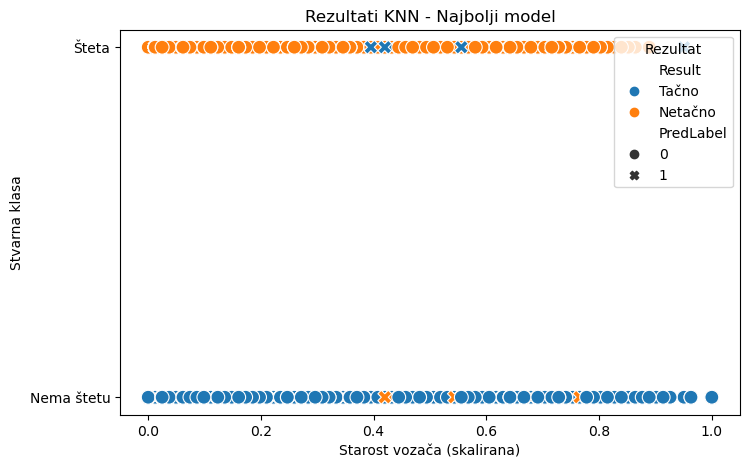

In [60]:
# Vizualizacija rezultata KNN po starosti (predikcija vs stvarno)
def plot_knn_results_by_age(X_test, y_test, y_pred, title):
    # X_test je numpy array sa skaliranim podacima, izvući kolonu DrivAge (indeks 0)
    driv_age = X_test[:, 0]  # DrivAge na indeksu 0
    df_vis = pd.DataFrame({
        'DrivAge': driv_age,
        'TrueLabel': y_test,
        'PredLabel': y_pred
    })
    df_vis['Result'] = np.where(df_vis['TrueLabel'] == df_vis['PredLabel'], 'Tačno', 'Netačno')

    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df_vis, x='DrivAge', y='TrueLabel', hue='Result', style='PredLabel', s=100)
    plt.yticks([0,1], ['Nema štetu', 'Šteta'])
    plt.xlabel('Starost vozača (skalirana)')
    plt.ylabel('Stvarna klasa')
    plt.title(title)
    plt.legend(title='Rezultat', loc='upper right')
    plt.show()

plot_knn_results_by_age(X_test, y_test, y_pred_test_best, 'Rezultati KNN - Najbolji model')


c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


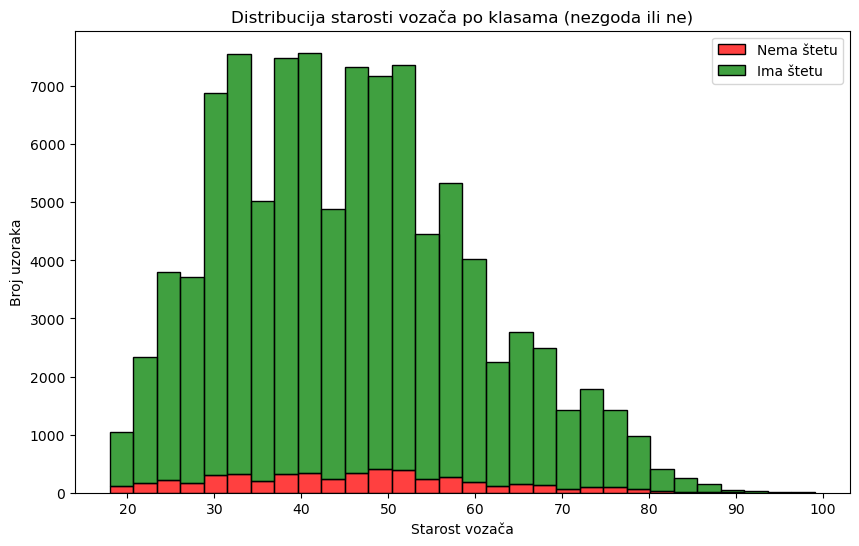

In [61]:
# Histogram starosti vozača podeljen po klasama štete
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='DrivAge', hue=(df['ClaimNb'] > 0), multiple='stack', bins=30, palette=['green','red'])
plt.xlabel('Starost vozača')
plt.ylabel('Broj uzoraka')
plt.title('Distribucija starosti vozača po klasama (nezgoda ili ne)')
plt.legend(['Nema štetu', 'Ima štetu'])
plt.show()

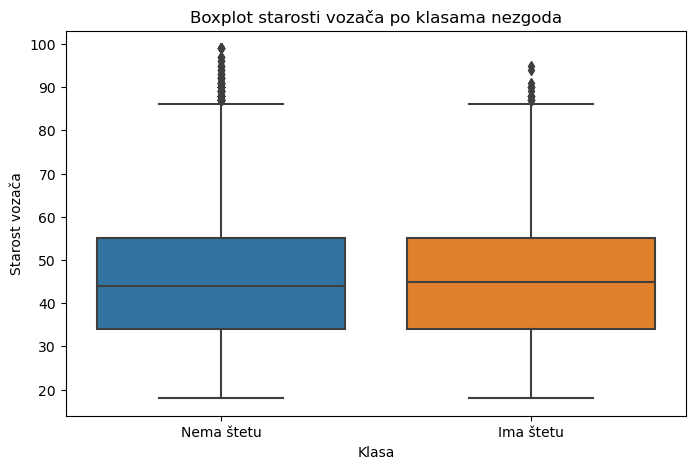

In [62]:
# Boxplot starosti u zavisnosti od toga da li je bilo štete
plt.figure(figsize=(8,5))
sns.boxplot(x=(df['ClaimNb'] > 0), y=df['DrivAge'])
plt.xticks([0,1], ['Nema štetu', 'Ima štetu'])
plt.xlabel('Klasa')
plt.ylabel('Starost vozača')
plt.title('Boxplot starosti vozača po klasama nezgoda')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27068\1319344237.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_pct = df_age_pred.groupby('AgeGroup')['Correct'].mean().reset_index()
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


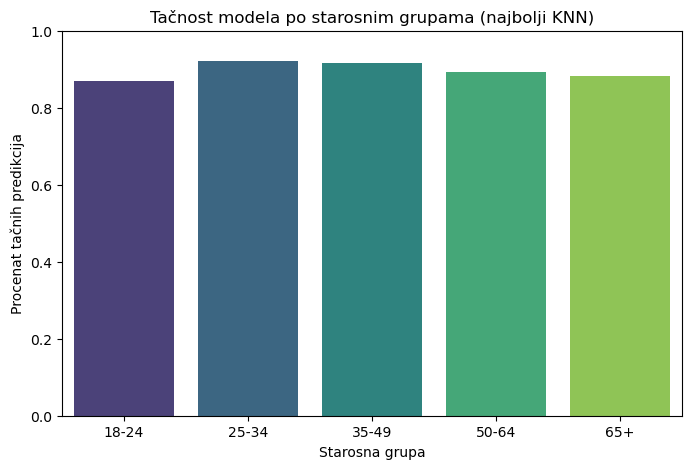

In [63]:
# Procenat tačnih i netačnih predikcija po starosnim grupama za najbolji model
age_bins = [18, 25, 35, 50, 65, 100]
age_labels = ['18-24', '25-34', '35-49', '50-64', '65+']

# Pošto je X_test skaliran, potrebno je vratiti starost u originalnu skalu
# Skaliranje: MinMaxScaler na osnovu originalnih podataka, sada inverzno skaliranje
# Tako da izračunamo starost originalno:

def inverse_minmax_scale(scaled_vals, orig_min, orig_max):
    return scaled_vals * (orig_max - orig_min) + orig_min

driv_age_scaled = X_test[:, 0]
driv_age_orig_min = df['DrivAge'].min()
driv_age_orig_max = df['DrivAge'].max()
driv_age_orig = inverse_minmax_scale(driv_age_scaled, driv_age_orig_min, driv_age_orig_max)

df_age_pred = pd.DataFrame({
    'DrivAge': driv_age_orig,
    'TrueLabel': y_test,
    'PredLabel': y_pred_test_best
})
df_age_pred['AgeGroup'] = pd.cut(df_age_pred['DrivAge'], bins=age_bins, labels=age_labels, right=False)
df_age_pred['Correct'] = df_age_pred['TrueLabel'] == df_age_pred['PredLabel']

correct_pct = df_age_pred.groupby('AgeGroup')['Correct'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='AgeGroup', y='Correct', data=correct_pct, palette='viridis')
plt.ylim(0,1)
plt.ylabel('Procenat tačnih predikcija')
plt.xlabel('Starosna grupa')
plt.title('Tačnost modela po starosnim grupama (najbolji KNN)')
plt.show()


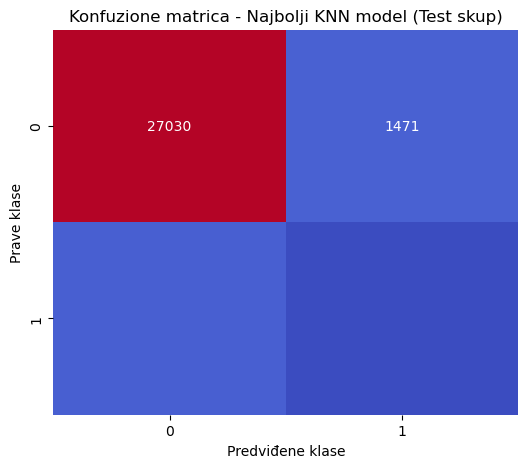

In [64]:
# Heatmap konfuzione matrice za najbolji model (za test skup, dodatno)
cm_best = confusion_matrix(y_test, y_pred_test_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.xlabel('Predviđene klase')
plt.ylabel('Prave klase')
plt.title('Konfuzione matrica - Najbolji KNN model (Test skup)')
plt.show()